# Linear Mixed Effects Models

With linear mixed effects models, we wish to model a linear
relationship for data points with inputs of varying type, categorized
into subgroups, and associated to a real-valued output.

We demonstrate with an example in Edward. A webpage version is available 
[here](http://edwardlib.org/tutorials/linear-mixed-effects-models).

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Normal
from observations import insteval

plt.style.use('ggplot')
ed.set_seed(42)

## Data

We use the `InstEval` data set from the popular
[lme4 R package](http://lme4.r-forge.r-project.org) (Bates, Mächler, Bolker, & Walker, 2015).
It is a data set of instructor evaluation ratings, where the inputs
(covariates) include categories such as `students` and
`departments`, and our response variable of interest is the instructor
evaluation rating.

In [2]:
data, metadata = insteval("~/data")
data = pd.DataFrame(data, columns=metadata['columns'])

# s - students - 1:2972
# d - instructors - codes that need to be remapped
# dept also needs to be remapped
data['s'] = data['s'] - 1
data['dcodes'] = data['d'].astype('category').cat.codes
data['deptcodes'] = data['dept'].astype('category').cat.codes
data['y'] = data['y'].values.astype(float)

train = data.sample(frac=0.8)
test = data.drop(train.index)

train.head()

,s,d,studage,lectage,service,dept,y,dcodes,deptcodes
66702,2714,474,8,5,1,1,4.0,248,0
51671,2074,102,8,1,1,1,2.0,55,0
35762,1456,139,6,4,0,12,2.0,73,11
43777,1772,2096,8,3,0,10,4.0,1092,9
4788,178,554,6,6,1,6,5.0,290,5


The data set denotes:
+ `students` as `s`
+ `instructors` as `d`
+ `departments` as `dept`
+ `service` as `service`

In [3]:
s_train = train['s'].values
d_train = train['dcodes'].values
dept_train = train['deptcodes'].values
y_train = train['y'].values
service_train = train['service'].values
n_obs_train = train.shape[0]

s_test = test['s'].values
d_test = test['dcodes'].values
dept_test = test['deptcodes'].values
y_test = test['y'].values
service_test = test['service'].values
n_obs_test = test.shape[0]

In [19]:
n_s = max(s_train) + 1  # number of students
n_d = max(d_train) + 1  # number of instructors
n_dept = max(dept_train) + 1  # number of departments
n_obs = train.shape[0]  # number of observations

print("Number of students: {}".format(n_s))
print("Number of instructors: {}".format(n_d))
print("Number of departments: {}".format(n_dept))
print("Number of observations: {}".format(n_obs))

Number of students: 2972
Number of instructors: 1128
Number of departments: 14
Number of observations: 58737


## Model

With linear regression, one makes an independence assumption where
each data point regresses with a constant slope among
each other. In our setting, the observations come from
groups which may have varying slopes and intercepts. Thus we'd like to
build a model that can capture this behavior (Gelman & Hill, 2006).

For examples of this phenomena:
+ The observations from a single student are not independent of
each other. Rather, some students may systematically give low (or
high) lecture ratings.
+ The observations from a single teacher are not independent of
each other. We expect good teachers to get generally good ratings and
bad teachers to get generally bad ratings.
+ The observations from a single department are not independent of
each other. One department may generally have dry material and thus be
rated lower than others.


Typical linear regression takes the form

\begin{equation*}
\mathbf{y} = \mathbf{X}\beta + \epsilon,
\end{equation*}

where $\mathbf{X}$ corresponds to fixed effects with coefficients
$\beta$ and $\epsilon$ corresponds to random noise,
$\epsilon\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$.

In a linear mixed effects model, we add an additional term
$\mathbf{Z}\eta$, where $\mathbf{Z}$ corresponds to random effects
with coefficients $\eta$. The model takes the form

\begin{align*}
\eta &\sim \mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{I}), \\
\mathbf{y} &= \mathbf{X}\beta + \mathbf{Z}\eta + \epsilon.
\end{align*}

Given data, the goal is to infer $\beta$, $\eta$, and $\sigma^2$,
where $\beta$ are model parameters ("fixed effects"), $\eta$ are
latent variables ("random effects"), and $\sigma^2$ is a variance
component parameter.

Because the random effects have mean 0, the data's mean is captured by
$\mathbf{X}\beta$. The random effects component $\mathbf{Z}\eta$
captures variations in the data (e.g.  Instructor \#54 is rated 1.4
points higher than the mean).

A natural question is the difference between fixed and random effects.
A fixed effect is an effect that is constant for a given population. A
random effect is an effect that varies for a given population (i.e.,
it may be constant within subpopulations but varies within the overall
population). We illustrate below in our example:

+ Select `service` as the fixed effect. It is a binary covariate
corresponding to whether the lecture belongs to the lecturer's main
department. No matter how much additional data we collect, it
can only take on the values in $0$ and $1$.
+ Select the categorical values of `students`, `teachers`,
and `departments` as the random effects. Given more
observations from the population of instructor evaluation ratings, we
may be looking at new students, teachers, or departments.

In the syntax of R's lme4 package (Bates et al., 2015), the model
can be summarized as

```
y ~ 1 + (1|students) + (1|instructor) + (1|dept) + service
```
where `1` denotes an intercept term,`(1|x)` denotes a
random effect for `x`, and `x` denotes a fixed effect.

In [5]:
# Set up placeholders for the data inputs.
s_ph = tf.placeholder(tf.int32, [None])
d_ph = tf.placeholder(tf.int32, [None])
dept_ph = tf.placeholder(tf.int32, [None])
service_ph = tf.placeholder(tf.float32, [None])

# Set up fixed effects.
mu = tf.get_variable("mu", [])
service = tf.get_variable("service", [])

sigma_s = tf.sqrt(tf.exp(tf.get_variable("sigma_s", [])))
sigma_d = tf.sqrt(tf.exp(tf.get_variable("sigma_d", [])))
sigma_dept = tf.sqrt(tf.exp(tf.get_variable("sigma_dept", [])))

# Set up random effects.
eta_s = Normal(loc=tf.zeros(n_s), scale=sigma_s * tf.ones(n_s))
eta_d = Normal(loc=tf.zeros(n_d), scale=sigma_d * tf.ones(n_d))
eta_dept = Normal(loc=tf.zeros(n_dept), scale=sigma_dept * tf.ones(n_dept))

yhat = (tf.gather(eta_s, s_ph) +
        tf.gather(eta_d, d_ph) +
        tf.gather(eta_dept, dept_ph) +
        mu + service * service_ph)
y = Normal(loc=yhat, scale=tf.ones(n_obs))

## Inference

Given data, we aim to infer the model's fixed and random effects.
In this analysis, we use variational inference with the
$\text{KL}(q\|p)$ divergence measure. We specify fully factorized
normal approximations for the random effects and pass in all training
data for inference. Under the algorithm, the fixed effects will be
estimated under a variational EM scheme.

In [6]:
q_eta_s = Normal(
    loc=tf.get_variable("q_eta_s/loc", [n_s]),
    scale=tf.nn.softplus(tf.get_variable("q_eta_s/scale", [n_s])))
q_eta_d = Normal(
    loc=tf.get_variable("q_eta_d/loc", [n_d]),
    scale=tf.nn.softplus(tf.get_variable("q_eta_d/scale", [n_d])))
q_eta_dept = Normal(
    loc=tf.get_variable("q_eta_dept/loc", [n_dept]),
    scale=tf.nn.softplus(tf.get_variable("q_eta_dept/scale", [n_dept])))

latent_vars = {
    eta_s: q_eta_s,
    eta_d: q_eta_d,
    eta_dept: q_eta_dept}
data = {
    y: y_train,
    s_ph: s_train,
    d_ph: d_train,
    dept_ph: dept_train,
    service_ph: service_train}
inference = ed.KLqp(latent_vars, data)

One way to critique the fitted model is a residual plot, i.e., a
plot of the difference between the predicted value and the observed
value for each data point. Below we manually run inference,
initializing the algorithm and performing individual updates within a
loop. We form residual plots as the algorithm progresses. This helps
us examine how the algorithm proceeds to infer the random and fixed
effects from data.

To form residuals, we first make predictions on test data. We do this
by copying `yhat` defined in the model and replacing its
dependence on random effects with their inferred means. During the
algorithm, we evaluate the predictions, feeding in test inputs.

We have also fit the same model (`y ~ service + (1|dept) + (1|s) + (1|d)`, 
fit on the entire `InstEval` dataset, specifically) in `lme4`.  We 
have saved the random effect estimates and will compare them to our 
learned parameters.

In [7]:
yhat_test = ed.copy(yhat, {
    eta_s: q_eta_s.mean(),
    eta_d: q_eta_d.mean(),
    eta_dept: q_eta_dept.mean()})

    1/10000 [  0%]                                ETA: 13907s | Loss: 860786.312

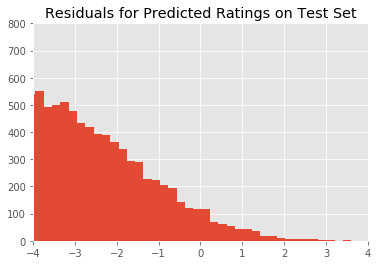

 2000/10000 [ 20%] ██████                         ETA: 46s | Loss: 97086.469

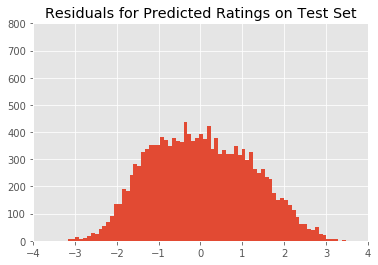

 4000/10000 [ 40%] ████████████                   ETA: 35s | Loss: 97106.094

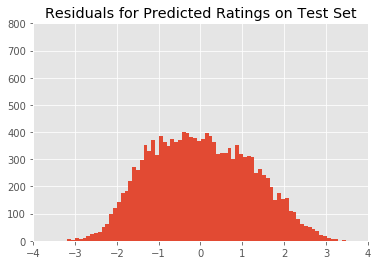

 6000/10000 [ 60%] ██████████████████             ETA: 22s | Loss: 97073.000

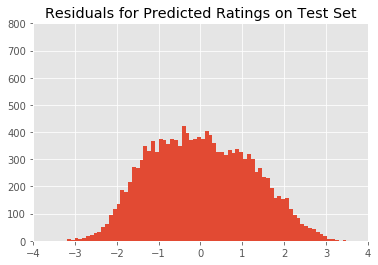

 8000/10000 [ 80%] ████████████████████████       ETA: 11s | Loss: 97065.883

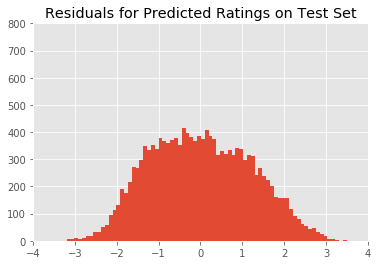

10000/10000 [100%] ██████████████████████████████ Elapsed: 62s | Loss: 97108.422


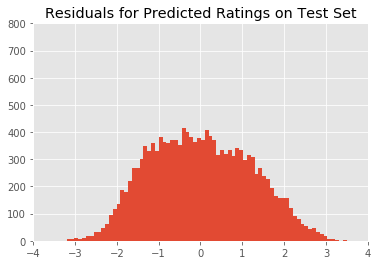

In [8]:
inference.initialize(n_print=2000, n_iter=10000)
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
  # Update and print progress of algorithm.
  info_dict = inference.update()
  inference.print_progress(info_dict)

  t = info_dict['t']
  if t == 1 or t % inference.n_print == 0:
    # Make predictions on test data.
    yhat_vals = yhat_test.eval(feed_dict={
        s_ph: s_test,
        d_ph: d_test,
        dept_ph: dept_test,
        service_ph: service_test})

    # Form residual plot.
    plt.title("Residuals for Predicted Ratings on Test Set")
    plt.xlim(-4, 4)
    plt.ylim(0, 800)
    plt.hist(yhat_vals - y_test, 75)
    plt.show()

## Criticism

Above, we described a method for diagnosing the fit of the model via
residual plots. See the residual plot at the end of the algorithm.

The residuals appear normally distributed with mean 0. This is a good
sanity check for the model.

We can also compare our learned parameters to those estimated by R's
`lme4`.  

In [9]:
student_effects_lme4 = pd.read_csv('data/insteval_student_ranefs_r.csv')
instructor_effects_lme4 = pd.read_csv('data/insteval_instructor_ranefs_r.csv')
dept_effects_lme4 = pd.read_csv('data/insteval_dept_ranefs_r.csv')

In [10]:
student_effects_edward = q_eta_s.mean().eval()
instructor_effects_edward = q_eta_d.mean().eval()
dept_effects_edward = q_eta_dept.mean().eval()

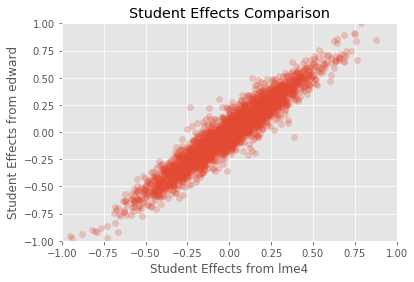

In [11]:
plt.title("Student Effects Comparison")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("Student Effects from lme4")
plt.ylabel("Student Effects from edward")
plt.scatter(student_effects_lme4["(Intercept)"],
            student_effects_edward,
            alpha=0.25)
plt.show()

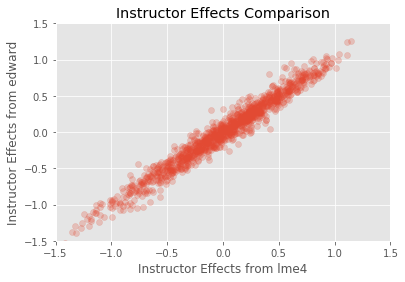

In [12]:
plt.title("Instructor Effects Comparison")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel("Instructor Effects from lme4")
plt.ylabel("Instructor Effects from edward")
plt.scatter(instructor_effects_lme4["(Intercept)"],
            instructor_effects_edward,
            alpha=0.25)
plt.show()

Great!  Our estimates for both student and instructor effects seem to
match those from `lme4` closely.  We have set up a slightly different 
model here (for example, our overall mean is regularized, as are our
variances for student, department, and instructor effects, which is not
true of `lme4`s model), and we have a different inference method, so we 
should not expect to find exactly the same parameters as `lme4`.  But 
it is reassuring that they match up closely!

In [13]:
#  Add in the intercept from R and edward
dept_effects_and_intercept_lme4 = 3.28259 + dept_effects_lme4["(Intercept)"]
dept_effects_and_intercept_edward = mu.eval() + dept_effects_edward

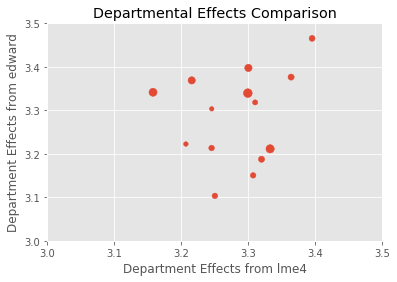

In [14]:
plt.title("Departmental Effects Comparison")
plt.xlim(3.0, 3.5)
plt.ylim(3.0, 3.5)
plt.xlabel("Department Effects from lme4")
plt.ylabel("Department Effects from edward")
plt.scatter(dept_effects_and_intercept_lme4,
            dept_effects_and_intercept_edward,
            s=0.01 * train.dept.value_counts())
plt.show()

Our department effects do not match up nearly as well with those from `lme4`.  
There are likely several reasons for this:
  *  We regularize the overal mean, while `lme4` doesn't, which causes the
  edward model to put some of the intercept into the department effects, 
  which are allowed to vary more widely since we learn a variance
  *  We are using 80% of the data to train the edward model, while our `lme4`
  estimate uses the whole `InstEval` data set
  *  The department effects are the weakest in the model and difficult to 
  estimate.

## Acknowledgments

We thank Mayank Agrawal for writing the initial version of this
tutorial.